# Phase retrieval with gradient descent
## Recovering the TinyTol pupil from a **saturated** PSF

In this demonstration there is a known phase solution. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import tensorflow as tf
import pickle

from funcs import *

In [2]:
# We used TensorFlow version 2.3.0
print(tf.__version__)

2.3.0


## Define physical constants

In [3]:
apix = 128 # number of pixels in the apeture
dpix = 256 # nuber of pixels on the detector

pix_size = 1e-6 # Sampling size in the focal plane (meters)
aperture = .02  # apeture size (diameter) (meters)
flen = .15      # focal length (meters)
wlen = 600e-9   # wavelength (meters)

# Scaling factor used to pad the apperture giving the desired focal plane sampling
factor = (wlen * flen) / (aperture * pix_size)

## Load in the TinyTol pupil

In [4]:
true_pupil = np.load('./tinytol.npy')

pad_pupil = pad(true_pupil, factor = factor)
original_psf = tf.cast(intensity(FFT(pad_pupil)), dtype = tf.float32)

## Original TinyTol PSF

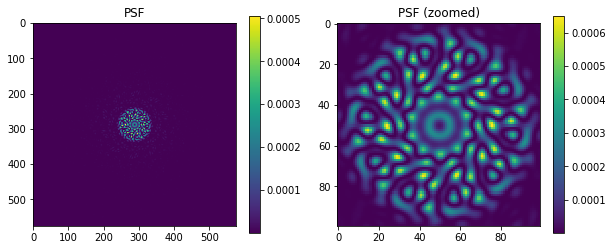

In [5]:
zoomed_psf = img_zoom(original_psf)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1); plt.imshow(normalise(original_psf), interpolation = 'none'); plt.title('PSF'); plt.colorbar()
plt.subplot(1, 2, 2); plt.imshow(normalise(zoomed_psf), interpolation = 'none'); plt.title('PSF (zoomed)'); plt.colorbar()
plt.show()

## Saturated TinyTol PSF

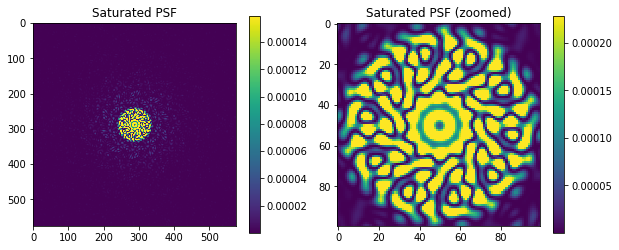

In [6]:
clip = 5e5
true_psf = tf.clip_by_value(original_psf, clip_value_min = 0, clip_value_max = clip)

zoomed_psf = img_zoom(true_psf)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1); plt.imshow(normalise(true_psf), interpolation = 'none'); plt.title('Saturated PSF'); plt.colorbar()
plt.subplot(1, 2, 2); plt.imshow(normalise(zoomed_psf), interpolation = 'none'); plt.title('Saturated PSF (zoomed)'); plt.colorbar()
plt.show()

## Initialized gradient descent
The pupil support is known and taken from the true pupil.

In [7]:
mag = tf.abs(true_pupil)

The phases are initialized randomly between -0.5 and 0.5 radians.

In [8]:
phases = tf.random.uniform((apix, apix), minval = -0.5, maxval = 0.5, seed = 0)
pupil = build_pupil(phases, np.abs(true_pupil))
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

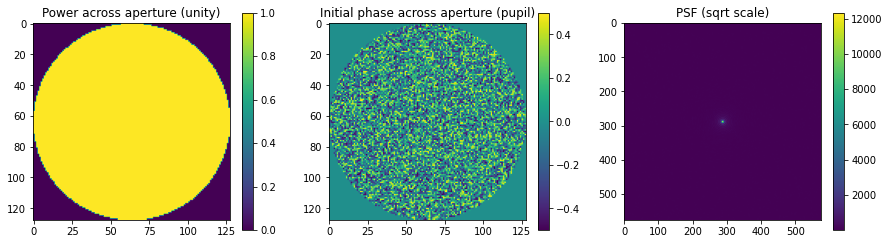

In [9]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1); plt.imshow(np.abs(pupil)); plt.colorbar()
plt.title('Power across aperture (unity)')

plt.subplot(1, 3, 2); plt.imshow(np.angle(pupil)); plt.colorbar()
plt.title('Initial phase across aperture (pupil)')

plt.subplot(1, 3, 3); plt.imshow(psf**0.5); plt.colorbar()
plt.title('PSF (sqrt scale)')

plt.show()

Since we know the pupil support, we only need to recover the phase, in our gradient descent we only need to calculate gradients with respect to the phase.

In [10]:
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

mag = tf.abs(pad_pupil)
pha = tf.Variable(tf.math.angle(pad_pupil))

In [11]:
results = {'psfs': [], 'original_psfs': [], 'pupils': [], 'errors': []}

## Run gradient descent
We use the MAE as our objective function.

In [7]:
def gradient_descent(phase, magnitude, epochs, learning_rate, results, save_rate = 100):
    
    adam = tf.optimizers.Adam(learning_rate)
    
    for i in range(epochs):
        
        with tf.GradientTape() as g:
            g.watch(phase)

            pad_pupil = build_pupil(phase, magnitude) 

            fft = FFT(pad_pupil)
            psf = intensity(fft)
            saturated_psf = tf.clip_by_value(psf, clip_value_min = 0, clip_value_max = 5e5)

            error = tf.reduce_mean(tf.abs(tf.subtract(true_psf, saturated_psf)))
            results['errors'].append(error.numpy())

            if i % save_rate == 0:
                if i > 1000:
                    save_rate = 250
                results['psfs'].append(saturated_psf)
                results['original_psfs'].append(psf)
                results['pupils'].append(pad_pupil[:apix, :apix])

            grads = g.gradient(error, phase)
        
        adam.apply_gradients(zip([grads], [phase]))
        
    results['psfs'].append(saturated_psf)
    results['pupils'].append(pad_pupil[:apix, :apix])
        
    return results

In [13]:
lr = 0.1
results = gradient_descent(pha, mag, 3000, lr, results)

lr = 0.01
results = gradient_descent(pha, mag, 1000, lr, results)

lr = 0.001
results = gradient_descent(pha, mag, 500, lr, results)

In [14]:
with open('./saturation.pkl', 'wb') as f:
    pickle.dump(results, f)

## Results

In [8]:
with open('./saturation.pkl', 'rb') as f:
    results = pickle.load(f)

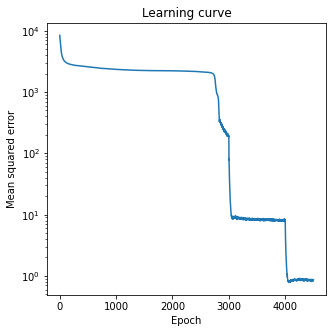

In [9]:
plt.figure(figsize = (5, 5))
plt.plot(results['errors']); plt.yscale('log')
plt.title('Learning curve'); plt.xlabel('Epoch'); plt.ylabel('Mean squared error')
plt.show()

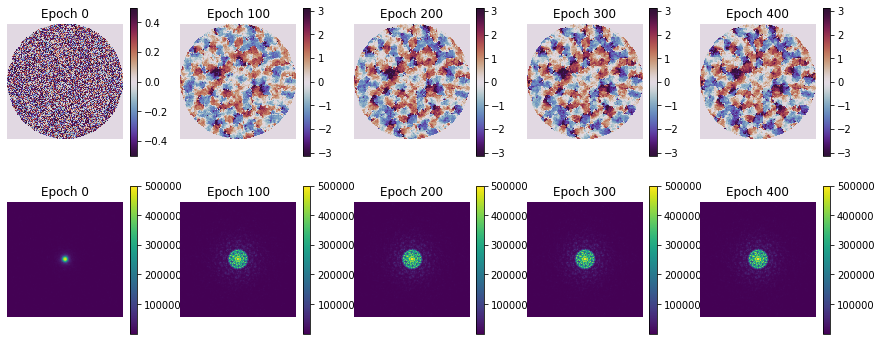

In [10]:
ncols = 5
save_rate = 100

plt.figure(figsize = (15, 6))
for i in range(ncols):
    plt.subplot(2, ncols, i + 1); plt.imshow(np.angle(results["pupils"][i]), cmap = 'twilight_shifted', interpolation = 'none'); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
    
    plt.subplot(2, ncols, ncols + i + 1); plt.imshow(results["psfs"][i]); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
plt.show()

## Recovered pupil and PSF

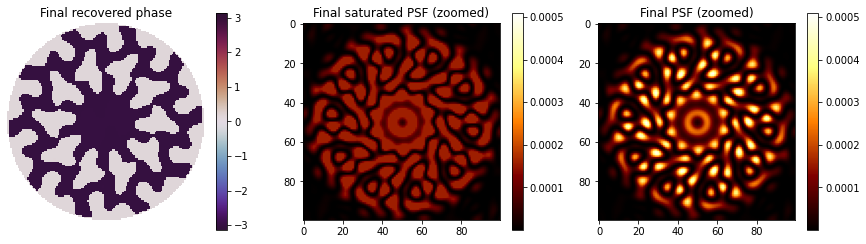

In [13]:
final_pupil = np.angle(results["pupils"][-1])
final_sat_psf = normalise(results["psfs"][-1])
final_psf = normalise(results["original_psfs"][-1])

final_pupil[final_pupil == 0] = None

zoomed_sat_psf = img_zoom(final_sat_psf)
zoomed_psf = img_zoom(final_psf)

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1); plt.imshow(final_pupil, cmap = 'twilight_shifted', interpolation = "none", vmin = -np.pi, vmax = np.pi);
plt.colorbar(); plt.title('Final recovered phase'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(zoomed_sat_psf, cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('Final saturated PSF (zoomed)')
plt.subplot(1, 3, 3); plt.imshow(zoomed_psf, cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('Final PSF (zoomed)')
plt.show()

## True TinyTol pupil and PSF

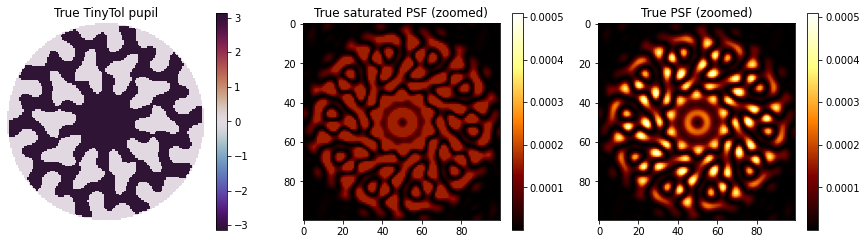

In [14]:
zoomed_sat_psf = img_zoom(normalise(true_psf))
zoomed_psf = img_zoom(normalise(original_psf))

true_pupil[true_pupil == 0] = None

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1); plt.imshow(np.angle(true_pupil), cmap = 'twilight_shifted', interpolation = "none", vmin = -np.pi, vmax = np.pi);
plt.colorbar(); plt.title('True TinyTol pupil'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(zoomed_sat_psf, cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('True saturated PSF (zoomed)')
plt.subplot(1, 3, 3); plt.imshow(zoomed_psf, cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('True PSF (zoomed)')
plt.show()